# GR00T Inference Timing Analysis

This notebook analyzes the inference time breakdown between:
- **Backbone** (Eagle VLM): Processes visual and language inputs
- **Action Head** (DiT diffusion model): Generates actions using flow matching

### Inference Modes Benchmarked:
1. **PyTorch Eager**: Standard PyTorch execution
2. **torch.compile**: PyTorch 2.0+ JIT compilation with `max-autotune` mode
3. **TensorRT**: Optimized DiT action head using TensorRT engine

In [ ]:
import os
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

import gr00t
from gr00t.data.dataset.lerobot_episode_loader import LeRobotEpisodeLoader
from gr00t.data.dataset.sharded_single_step_dataset import extract_step_data
from gr00t.data.embodiment_tags import EmbodimentTag
from gr00t.policy.gr00t_policy import Gr00tPolicy

# Import set_seed for reproducibility across PyTorch and TensorRT benchmarks
from standalone_inference_script import set_seed
set_seed(42)

In [ ]:
# Configuration
MODEL_PATH = "nvidia/GR00T-N1.6-3B"

REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATASET_PATH = os.path.join(REPO_PATH, "demo_data/gr1.PickNPlace")
EMBODIMENT_TAG = "gr1"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Load the Policy Model

In [ ]:
# Load the policy
policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EmbodimentTag(EMBODIMENT_TAG),
    device=device,
    strict=True,
)

print(f"Model loaded successfully!")
print(f"Action horizon: {policy.model.action_head.action_horizon}")
print(f"Num inference timesteps (denoising steps): {policy.model.action_head.num_inference_timesteps}")

## Load Dataset and Prepare Sample Observation

In [4]:
# Get modality config from policy
modality_config = policy.get_modality_config()
print("Modality config keys:", modality_config.keys())

# Load dataset
dataset = LeRobotEpisodeLoader(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="torchcodec",
    video_backend_kwargs=None,
)
print(f"Dataset loaded with {len(dataset)} episodes")

Modality config keys: dict_keys(['video', 'state', 'action', 'language'])
Dataset loaded with 5 episodes


In [5]:
# Print detailed modality config
print("Modality Configuration Details:")
print("=" * 60)
for modality_name, config in modality_config.items():
    print(f"\n{modality_name.upper()}:")
    print(f"  delta_indices: {config.delta_indices}")
    print(f"  modality_keys: {config.modality_keys}")
    if config.sin_cos_embedding_keys:
        print(f"  sin_cos_embedding_keys: {config.sin_cos_embedding_keys}")
    if config.action_configs:
        print(f"  action_configs:")
        for i, ac in enumerate(config.action_configs):
            print(f"    [{i}] {config.modality_keys[i]}: rep={ac.rep.value}, type={ac.type.value}")

Modality Configuration Details:

VIDEO:
  delta_indices: [0]
  modality_keys: ['ego_view_bg_crop_pad_res256_freq20']

STATE:
  delta_indices: [0]
  modality_keys: ['left_arm', 'right_arm', 'left_hand', 'right_hand', 'waist']
  sin_cos_embedding_keys: ['left_arm', 'right_arm', 'left_hand', 'right_hand', 'waist']

ACTION:
  delta_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  modality_keys: ['left_arm', 'right_arm', 'left_hand', 'right_hand', 'waist']
  action_configs:
    [0] left_arm: rep=relative, type=non_eef
    [1] right_arm: rep=relative, type=non_eef
    [2] left_hand: rep=relative, type=non_eef
    [3] right_hand: rep=relative, type=non_eef
    [4] waist: rep=absolute, type=non_eef

LANGUAGE:
  delta_indices: [0]
  modality_keys: ['task']


In [6]:
# Extract a sample step data
episode_data = dataset[0]
step_data = extract_step_data(
    episode_data, 
    step_index=0, 
    modality_configs=modality_config, 
    embodiment_tag=EmbodimentTag(EMBODIMENT_TAG), 
    allow_padding=False
)

# Prepare observation in the format expected by the policy
observation = {
    "video": {k: np.stack(step_data.images[k])[None] for k in step_data.images},
    "state": {k: step_data.states[k][None] for k in step_data.states},
    "action": {k: step_data.actions[k][None] for k in step_data.actions},
    "language": {
        modality_config["language"].modality_keys[0]: [[step_data.text]],
    }
}

print("\nObservation shapes:")
print(f"  Video keys: {list(observation['video'].keys())}")
for k, v in observation['video'].items():
    print(f"    {k}: {v.shape}")
print(f"  State keys: {list(observation['state'].keys())}")
for k, v in observation['state'].items():
    print(f"    {k}: {v.shape}")
print(f"  Action keys: {list(observation['action'].keys())}")
for k, v in observation['action'].items():
    print(f"    {k}: {v.shape}")
print(f"  Language: {observation['language']}")


Observation shapes:
  Video keys: ['ego_view_bg_crop_pad_res256_freq20']
    ego_view_bg_crop_pad_res256_freq20: (1, 1, 256, 256, 3)
  State keys: ['left_arm', 'right_arm', 'left_hand', 'right_hand', 'waist']
    left_arm: (1, 1, 7)
    right_arm: (1, 1, 7)
    left_hand: (1, 1, 6)
    right_hand: (1, 1, 6)
    waist: (1, 1, 3)
  Action keys: ['left_arm', 'right_arm', 'left_hand', 'right_hand', 'waist']
    left_arm: (1, 16, 7)
    right_arm: (1, 16, 7)
    left_hand: (1, 16, 6)
    right_hand: (1, 16, 6)
    waist: (1, 16, 3)
  Language: {'task': [['pick the pear from the counter and place it in the plate']]}


## Timing Analysis: Backbone vs Action Head

We will measure:
1. **Full E2E inference**: Complete `get_action()` call
2. **Backbone only**: `prepare_input()` + `backbone()` forward pass
3. **Action head only**: `action_head.get_action()` using backbone output

In [7]:
# Import shared utilities from benchmark script
from benchmark_inference import (
    _rec_to_dtype,
    prepare_model_inputs as _prepare_model_inputs,
    benchmark_data_processing,
)


def prepare_model_inputs(policy, observation):
    """
    Wrapper that calls the shared prepare_model_inputs with return_states=True.
    Returns (collated_inputs, states) for use in this notebook.
    """
    return _prepare_model_inputs(policy, observation, return_states=True)

In [8]:
# Warmup runs to ensure CUDA kernels are compiled
print("Running warmup iterations...")
for _ in range(3):
    with torch.inference_mode():
        _ = policy.get_action(observation)
torch.cuda.synchronize()
print("Warmup complete!")

Running warmup iterations...
Warmup complete!


In [9]:
# Timing configuration
NUM_ITERATIONS = 20  # Number of iterations for averaging

# Storage for timing results
timing_results = {
    "e2e_time": [],
    "data_prep_time": [],
    "backbone_time": [],
    "action_head_time": [],
}

### Measure Full E2E Inference Time

In [10]:
print("Measuring full E2E inference time...")
for i in range(NUM_ITERATIONS):
    torch.cuda.synchronize()
    start = time.perf_counter()
    
    with torch.inference_mode():
        action, _ = policy.get_action(observation)
    
    torch.cuda.synchronize()
    end = time.perf_counter()
    timing_results["e2e_time"].append(end - start)

e2e_mean = np.mean(timing_results["e2e_time"]) * 1000
e2e_std = np.std(timing_results["e2e_time"]) * 1000
print(f"E2E inference time: {e2e_mean:.2f} ± {e2e_std:.2f} ms")

Measuring full E2E inference time...
E2E inference time: 148.62 ± 31.66 ms


### Measure Component-wise Inference Time (Backbone + Action Head)

In [11]:
print("Measuring component-wise inference time...")

# 1. Data preparation timing (with proper warmup to reduce CPU variance)
# Uses benchmark_data_processing which includes GC and 10 warmup iterations
print("  Benchmarking data preparation (with CPU warmup)...")
data_prep_times_ms = benchmark_data_processing(policy, observation, num_iterations=NUM_ITERATIONS, warmup=10)
timing_results["data_prep_time"] = (data_prep_times_ms / 1000).tolist()  # Convert back to seconds for consistency

# 2. Backbone and Action Head timing (GPU-bound)
print("  Benchmarking backbone and action head...")
for i in range(NUM_ITERATIONS):
    collated_inputs, states = prepare_model_inputs(policy, observation)
    
    # Backbone timing
    torch.cuda.synchronize()
    start_backbone = time.perf_counter()
    
    with torch.inference_mode():
        backbone_inputs, action_inputs = policy.model.prepare_input(collated_inputs)
        backbone_outputs = policy.model.backbone(backbone_inputs)
    
    torch.cuda.synchronize()
    end_backbone = time.perf_counter()
    timing_results["backbone_time"].append(end_backbone - start_backbone)
    
    # Action head timing
    torch.cuda.synchronize()
    start_action = time.perf_counter()
    
    with torch.inference_mode():
        action_outputs = policy.model.action_head.get_action(backbone_outputs, action_inputs)
    
    torch.cuda.synchronize()
    end_action = time.perf_counter()
    timing_results["action_head_time"].append(end_action - start_action)

print(f"\nComponent-wise timing (averaged over {NUM_ITERATIONS} iterations):")
print(f"  Data preparation: {np.mean(timing_results['data_prep_time'])*1000:.2f} ± {np.std(timing_results['data_prep_time'])*1000:.2f} ms")
print(f"  Backbone:         {np.mean(timing_results['backbone_time'])*1000:.2f} ± {np.std(timing_results['backbone_time'])*1000:.2f} ms")
print(f"  Action head:      {np.mean(timing_results['action_head_time'])*1000:.2f} ± {np.std(timing_results['action_head_time'])*1000:.2f} ms")

Measuring component-wise inference time...
  Benchmarking data preparation (with CPU warmup)...
  Benchmarking backbone and action head...

Component-wise timing (averaged over 20 iterations):
  Data preparation: 4.72 ± 0.72 ms
  Backbone:         37.96 ± 2.80 ms
  Action head:      94.28 ± 5.95 ms


## Results Summary

In [12]:
# Create summary DataFrame
summary_data = {
    "Component": [
        "Full E2E Inference",
        "Data Preparation",
        "Backbone (VLM)",
        "Action Head",
    ],
    "Mean (ms)": [
        np.mean(timing_results["e2e_time"]) * 1000,
        np.mean(timing_results["data_prep_time"]) * 1000,
        np.mean(timing_results["backbone_time"]) * 1000,
        np.mean(timing_results["action_head_time"]) * 1000,
    ],
    "Std (ms)": [
        np.std(timing_results["e2e_time"]) * 1000,
        np.std(timing_results["data_prep_time"]) * 1000,
        np.std(timing_results["backbone_time"]) * 1000,
        np.std(timing_results["action_head_time"]) * 1000,
    ],
    "Max Freq (Hz)": [
        1000 / (np.mean(timing_results["e2e_time"]) * 1000),
        1000 / (np.mean(timing_results["data_prep_time"]) * 1000),
        1000 / (np.mean(timing_results["backbone_time"]) * 1000),
        1000 / (np.mean(timing_results["action_head_time"]) * 1000),
    ]
}

df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("TIMING SUMMARY")
print("="*80)
print(df.to_string(index=False))


TIMING SUMMARY
         Component  Mean (ms)  Std (ms)  Max Freq (Hz)
Full E2E Inference 148.622379 31.658442       6.728462
  Data Preparation   4.720365  0.724041     211.848030
    Backbone (VLM)  37.961487  2.802250      26.342488
       Action Head  94.281011  5.948398      10.606590


In [13]:
# Calculate percentage breakdown
total_component_time = (
    np.mean(timing_results["data_prep_time"]) + 
    np.mean(timing_results["backbone_time"]) + 
    np.mean(timing_results["action_head_time"])
)

print("\n" + "="*80)
print("TIME BREAKDOWN (%)")
print("="*80)
print(f"Data Preparation: {100*np.mean(timing_results['data_prep_time'])/total_component_time:.1f}%")
print(f"Backbone (VLM):   {100*np.mean(timing_results['backbone_time'])/total_component_time:.1f}%")
print(f"Action Head:      {100*np.mean(timing_results['action_head_time'])/total_component_time:.1f}%")


TIME BREAKDOWN (%)
Data Preparation: 3.4%
Backbone (VLM):   27.7%
Action Head:      68.8%


## Visualization

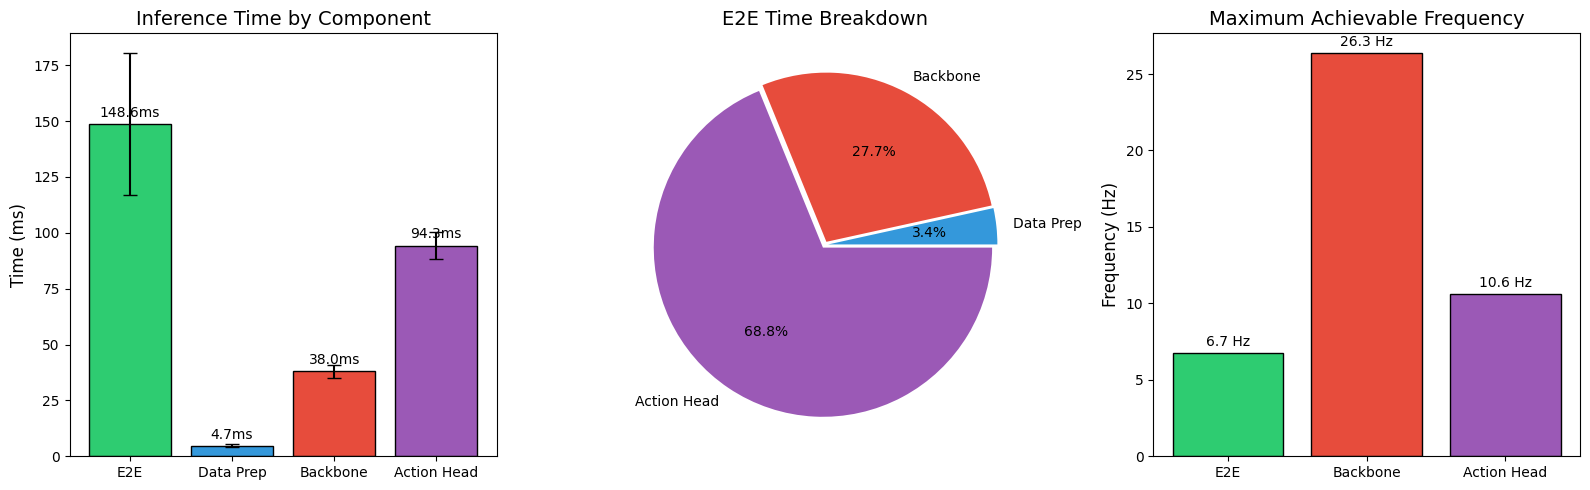

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Bar chart of average times
ax1 = axes[0]
components = ["E2E", "Data Prep", "Backbone", "Action Head"]
times = [np.mean(timing_results[k])*1000 for k in timing_results.keys()]
stds = [np.std(timing_results[k])*1000 for k in timing_results.keys()]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

bars = ax1.bar(components, times, yerr=stds, capsize=5, color=colors, edgecolor='black')
ax1.set_ylabel('Time (ms)', fontsize=12)
ax1.set_title('Inference Time by Component', fontsize=14)
ax1.tick_params(axis='x', rotation=0)

# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax1.annotate(f'{time_val:.1f}ms',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Plot 2: Pie chart of time breakdown
ax2 = axes[1]
breakdown_labels = ['Data Prep', 'Backbone', 'Action Head']
breakdown_times = [
    np.mean(timing_results['data_prep_time']),
    np.mean(timing_results['backbone_time']),
    np.mean(timing_results['action_head_time'])
]
breakdown_colors = ['#3498db', '#e74c3c', '#9b59b6']

wedges, texts, autotexts = ax2.pie(breakdown_times, labels=breakdown_labels, 
                                   autopct='%1.1f%%', colors=breakdown_colors,
                                   explode=(0.02, 0.02, 0.02))
ax2.set_title('E2E Time Breakdown', fontsize=14)

# Plot 3: Max frequency comparison
ax3 = axes[2]
freq_labels = ['E2E', 'Backbone', 'Action Head']
frequencies = [
    1000 / (np.mean(timing_results['e2e_time']) * 1000),
    1000 / (np.mean(timing_results['backbone_time']) * 1000),
    1000 / (np.mean(timing_results['action_head_time']) * 1000),
]
freq_colors = ['#2ecc71', '#e74c3c', '#9b59b6']

bars3 = ax3.bar(freq_labels, frequencies, color=freq_colors, edgecolor='black')
ax3.set_ylabel('Frequency (Hz)', fontsize=12)
ax3.set_title('Maximum Achievable Frequency', fontsize=14)

# Add value labels on bars
for bar, freq in zip(bars3, frequencies):
    height = bar.get_height()
    ax3.annotate(f'{freq:.1f} Hz',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Detailed Denoising Steps Analysis

The action head uses a flow-matching diffusion process with multiple denoising steps. Let's analyze how the number of denoising steps affects inference time.

In [15]:
# Get current number of denoising steps
original_num_steps = policy.model.action_head.num_inference_timesteps
print(f"Original number of denoising steps: {original_num_steps}")

# Test different numbers of denoising steps
denoising_steps_to_test = [1, 2, 4, 8, 16]
denoising_timing_results = {}

# Prepare inputs once
with torch.inference_mode():
    collated_inputs, states = prepare_model_inputs(policy, observation)
    backbone_inputs, action_inputs = policy.model.prepare_input(collated_inputs)
    backbone_outputs = policy.model.backbone(backbone_inputs)

print("\nMeasuring action head time for different denoising steps...")
for num_steps in denoising_steps_to_test:
    # Temporarily change the number of denoising steps
    policy.model.action_head.num_inference_timesteps = num_steps
    
    times = []
    for _ in range(NUM_ITERATIONS):
        torch.cuda.synchronize()
        start = time.perf_counter()
        
        with torch.inference_mode():
            _ = policy.model.action_head.get_action(backbone_outputs, action_inputs)
        
        torch.cuda.synchronize()
        end = time.perf_counter()
        times.append(end - start)
    
    denoising_timing_results[num_steps] = times
    print(f"  {num_steps} steps: {np.mean(times)*1000:.2f} +/- {np.std(times)*1000:.2f} ms")

# Restore original number of steps
policy.model.action_head.num_inference_timesteps = original_num_steps

Original number of denoising steps: 4

Measuring action head time for different denoising steps...
  1 steps: 24.28 +/- 1.78 ms


  2 steps: 46.60 +/- 2.38 ms
  4 steps: 90.98 +/- 3.11 ms
  8 steps: 186.94 +/- 7.32 ms
  16 steps: 363.41 +/- 6.15 ms


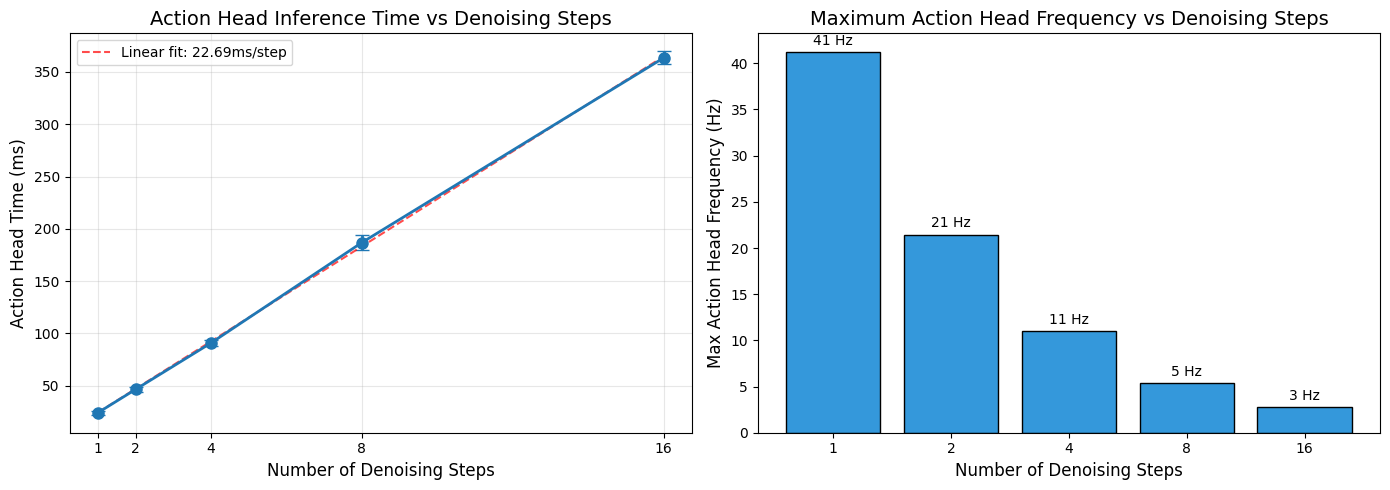

In [16]:
# Plot denoising steps vs time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Time vs denoising steps
ax1 = axes[0]
steps = list(denoising_timing_results.keys())
times = [np.mean(denoising_timing_results[s])*1000 for s in steps]
stds = [np.std(denoising_timing_results[s])*1000 for s in steps]

ax1.errorbar(steps, times, yerr=stds, fmt='o-', linewidth=2, markersize=8, capsize=5)
ax1.set_xlabel('Number of Denoising Steps', fontsize=12)
ax1.set_ylabel('Action Head Time (ms)', fontsize=12)
ax1.set_title('Action Head Inference Time vs Denoising Steps', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(steps)

# Add linear fit line
z = np.polyfit(steps, times, 1)
p = np.poly1d(z)
ax1.plot(steps, p(steps), 'r--', alpha=0.7, label=f'Linear fit: {z[0]:.2f}ms/step')
ax1.legend()

# Plot 2: Frequency vs denoising steps
ax2 = axes[1]
freqs = [1000/t for t in times]

ax2.bar(range(len(steps)), freqs, tick_label=[str(s) for s in steps], 
        color='#3498db', edgecolor='black')
ax2.set_xlabel('Number of Denoising Steps', fontsize=12)
ax2.set_ylabel('Max Action Head Frequency (Hz)', fontsize=12)
ax2.set_title('Maximum Action Head Frequency vs Denoising Steps', fontsize=14)

# Add value labels
for i, (step, freq) in enumerate(zip(steps, freqs)):
    ax2.annotate(f'{freq:.0f} Hz', xy=(i, freq), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## PyTorch Summary

This section analyzed the inference timing breakdown for the GR00T model with PyTorch:

### Key Findings:

1. **Backbone vs Action Head Split**: The backbone (VLM) and action head (diffusion model) are the two main components of inference.

2. **Denoising Steps Trade-off**: Fewer denoising steps lead to faster inference but may affect action quality.

In [17]:
# Final summary print
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nHardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Model: {MODEL_PATH}")
print(f"Action Horizon: {policy.model.action_head.action_horizon}")
print(f"Denoising Steps: {policy.model.action_head.num_inference_timesteps}")
print(f"\nTiming Results:")
print(f"  E2E Inference:  {np.mean(timing_results['e2e_time'])*1000:.2f} ms ({1000/(np.mean(timing_results['e2e_time'])*1000):.1f} Hz)")
print(f"  Backbone Only:  {np.mean(timing_results['backbone_time'])*1000:.2f} ms ({1000/(np.mean(timing_results['backbone_time'])*1000):.1f} Hz)")
print(f"  Action Head:    {np.mean(timing_results['action_head_time'])*1000:.2f} ms ({1000/(np.mean(timing_results['action_head_time'])*1000):.1f} Hz)")
print("\n" + "="*80)


FINAL SUMMARY

Hardware: NVIDIA H100 80GB HBM3
Model: nvidia/GR00T-N1.6-3B
Action Horizon: 50
Denoising Steps: 4

Timing Results:
  E2E Inference:  148.62 ms (6.7 Hz)
  Backbone Only:  37.96 ms (26.3 Hz)
  Action Head:    94.28 ms (10.6 Hz)



## torch.compile Inference Timing

PyTorch 2.0+ provides `torch.compile()` which can significantly accelerate model inference through graph optimization and kernel fusion. Let's measure the performance with `torch.compile` using `max-autotune` mode.

**Note:** The first inference after compilation will be slower due to JIT compilation overhead. We account for this with additional warmup iterations.


In [18]:
# Load a fresh policy for torch.compile
print("Loading fresh policy for torch.compile...")
policy_compiled = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EmbodimentTag(EMBODIMENT_TAG),
    device=device,
    strict=True,
)

# Apply torch.compile with max-autotune mode
print("Applying torch.compile with mode='max-autotune'...")
policy_compiled.model.action_head.model.forward = torch.compile(policy_compiled.model.action_head.model.forward, mode="max-autotune")

# Enable cuDNN benchmark for additional optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

print("torch.compile policy ready!")


Loading fresh policy for torch.compile...


Tune backbone llm: False
Tune backbone visual: False
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.q_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.k_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.v_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.o_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.q_norm.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.k_norm.weight
Backbone trainable parameter: model.language_model.model.layers.12.mlp.gate_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.mlp.up_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.mlp.down_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.input_layernorm.weight
Backbone trainable parameter: model.language_mode

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Applying torch.compile with mode='max-autotune'...
torch.compile policy ready!


In [19]:
# Warmup runs for torch.compile - extra iterations needed for JIT compilation
print("Running torch.compile warmup iterations (this may take a while due to JIT compilation)...")
for i in range(5):  # More warmup iterations for torch.compile
    with torch.inference_mode():
        _ = policy_compiled.get_action(observation)
    if i == 0:
        print("  First inference complete (JIT compilation triggered)")
torch.cuda.synchronize()
print("torch.compile warmup complete!")

# Storage for torch.compile timing results
compile_timing_results = {
    "e2e_time": [],
    "data_prep_time": [],
    "backbone_time": [],
    "action_head_time": [],
}


Running torch.compile warmup iterations (this may take a while due to JIT compilation)...


  First inference complete (JIT compilation triggered)
torch.compile warmup complete!


### Measure torch.compile E2E Inference Time


In [20]:
print("Measuring torch.compile full E2E inference time...")
for i in range(NUM_ITERATIONS):
    torch.cuda.synchronize()
    start = time.perf_counter()
    
    with torch.inference_mode():
        action, _ = policy_compiled.get_action(observation)
    
    torch.cuda.synchronize()
    end = time.perf_counter()
    compile_timing_results["e2e_time"].append(end - start)

e2e_mean = np.mean(compile_timing_results["e2e_time"]) * 1000
e2e_std = np.std(compile_timing_results["e2e_time"]) * 1000
print(f"torch.compile E2E inference time: {e2e_mean:.2f} ± {e2e_std:.2f} ms")


Measuring torch.compile full E2E inference time...
torch.compile E2E inference time: 69.38 ± 30.01 ms


### Measure torch.compile Component-wise Inference Time


In [21]:
# Note: torch.compile optimizes the entire model graph, so component-wise timing
# may not reflect the same optimizations as the E2E measurement.
# However, we measure them for comparison purposes.

# Data preparation is the same regardless of inference mode (torch.compile doesn't affect it)
# Use the shared data preparation timing from PyTorch Eager benchmark for consistency
compile_timing_results["data_prep_time"] = timing_results["data_prep_time"].copy()

print("Measuring torch.compile component-wise inference time...")
print("  (Using shared data preparation timing from PyTorch Eager benchmark)")

for i in range(NUM_ITERATIONS):
    collated_inputs, states = prepare_model_inputs(policy_compiled, observation)
    
    # 1. Backbone timing
    torch.cuda.synchronize()
    start_backbone = time.perf_counter()
    
    with torch.inference_mode():
        backbone_inputs, action_inputs = policy_compiled.model.prepare_input(collated_inputs)
        backbone_outputs = policy_compiled.model.backbone(backbone_inputs)
    
    torch.cuda.synchronize()
    end_backbone = time.perf_counter()
    compile_timing_results["backbone_time"].append(end_backbone - start_backbone)
    
    # 2. Action head timing
    torch.cuda.synchronize()
    start_action = time.perf_counter()
    
    with torch.inference_mode():
        action_outputs = policy_compiled.model.action_head.get_action(backbone_outputs, action_inputs)
    
    torch.cuda.synchronize()
    end_action = time.perf_counter()
    compile_timing_results["action_head_time"].append(end_action - start_action)

print(f"\ntorch.compile Component-wise timing (averaged over {NUM_ITERATIONS} iterations):")
print(f"  Data preparation:     {np.mean(compile_timing_results['data_prep_time'])*1000:.2f} ± {np.std(compile_timing_results['data_prep_time'])*1000:.2f} ms (shared)")
print(f"  Backbone:             {np.mean(compile_timing_results['backbone_time'])*1000:.2f} ± {np.std(compile_timing_results['backbone_time'])*1000:.2f} ms")
print(f"  Action head:          {np.mean(compile_timing_results['action_head_time'])*1000:.2f} ± {np.std(compile_timing_results['action_head_time'])*1000:.2f} ms")


Measuring torch.compile component-wise inference time...
  (Using shared data preparation timing from PyTorch Eager benchmark)

torch.compile Component-wise timing (averaged over 20 iterations):
  Data preparation:     4.72 ± 0.72 ms (shared)
  Backbone:             36.71 ± 1.44 ms
  Action head:          12.56 ± 0.07 ms


### PyTorch (Eager) vs torch.compile Comparison


In [22]:
# Create comparison DataFrame: PyTorch Eager vs torch.compile
compile_comparison_data = {
    "Component": [
        "Full E2E Inference",
        "Data Preparation",
        "Backbone (VLM)",
        "Action Head",
    ],
    "PyTorch Eager (ms)": [
        np.mean(timing_results["e2e_time"]) * 1000,
        np.mean(timing_results["data_prep_time"]) * 1000,
        np.mean(timing_results["backbone_time"]) * 1000,
        np.mean(timing_results["action_head_time"]) * 1000,
    ],
    "torch.compile (ms)": [
        np.mean(compile_timing_results["e2e_time"]) * 1000,
        np.mean(compile_timing_results["data_prep_time"]) * 1000,
        np.mean(compile_timing_results["backbone_time"]) * 1000,
        np.mean(compile_timing_results["action_head_time"]) * 1000,
    ],
}

# Calculate speedup
compile_comparison_data["Speedup"] = [
    compile_comparison_data["PyTorch Eager (ms)"][i] / compile_comparison_data["torch.compile (ms)"][i] 
    if compile_comparison_data["torch.compile (ms)"][i] > 0 else 0
    for i in range(len(compile_comparison_data["Component"]))
]

# Calculate max frequency
compile_comparison_data["Eager (Hz)"] = [1000 / t if t > 0 else 0 for t in compile_comparison_data["PyTorch Eager (ms)"]]
compile_comparison_data["Compiled (Hz)"] = [1000 / t if t > 0 else 0 for t in compile_comparison_data["torch.compile (ms)"]]

df_compile_comparison = pd.DataFrame(compile_comparison_data)

print("\n" + "="*100)
print("PYTORCH EAGER vs torch.compile COMPARISON")
print("="*100)
print(df_compile_comparison.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\n" + "="*100)
print("KEY INSIGHTS")
print("="*100)

# E2E speedup
e2e_speedup = compile_comparison_data["PyTorch Eager (ms)"][0] / compile_comparison_data["torch.compile (ms)"][0]
print(f"\n✓ E2E Speedup: {e2e_speedup:.2f}x {'faster' if e2e_speedup > 1 else 'slower'} with torch.compile")

# Action head speedup
ah_speedup = compile_comparison_data["PyTorch Eager (ms)"][3] / compile_comparison_data["torch.compile (ms)"][3]
print(f"✓ Action Head Speedup: {ah_speedup:.2f}x {'faster' if ah_speedup > 1 else 'slower'} with torch.compile")

# Backbone speedup
bb_speedup = compile_comparison_data["PyTorch Eager (ms)"][2] / compile_comparison_data["torch.compile (ms)"][2]
print(f"✓ Backbone Speedup: {bb_speedup:.2f}x {'faster' if bb_speedup > 1 else 'slower'} with torch.compile")

# Frequency improvement
eager_hz = 1000 / compile_comparison_data["PyTorch Eager (ms)"][0]
compiled_hz = 1000 / compile_comparison_data["torch.compile (ms)"][0]
print(f"\n✓ E2E Frequency: {eager_hz:.1f} Hz (Eager) → {compiled_hz:.1f} Hz (Compiled)")



PYTORCH EAGER vs torch.compile COMPARISON
         Component  PyTorch Eager (ms)  torch.compile (ms)  Speedup  Eager (Hz)  Compiled (Hz)
Full E2E Inference              148.62               69.38     2.14        6.73          14.41
  Data Preparation                4.72                4.72     1.00      211.85         211.85
    Backbone (VLM)               37.96               36.71     1.03       26.34          27.24
       Action Head               94.28               12.56     7.50       10.61          79.59

KEY INSIGHTS

✓ E2E Speedup: 2.14x faster with torch.compile
✓ Action Head Speedup: 7.50x faster with torch.compile
✓ Backbone Speedup: 1.03x faster with torch.compile

✓ E2E Frequency: 6.7 Hz (Eager) → 14.4 Hz (Compiled)


### torch.compile Visualization


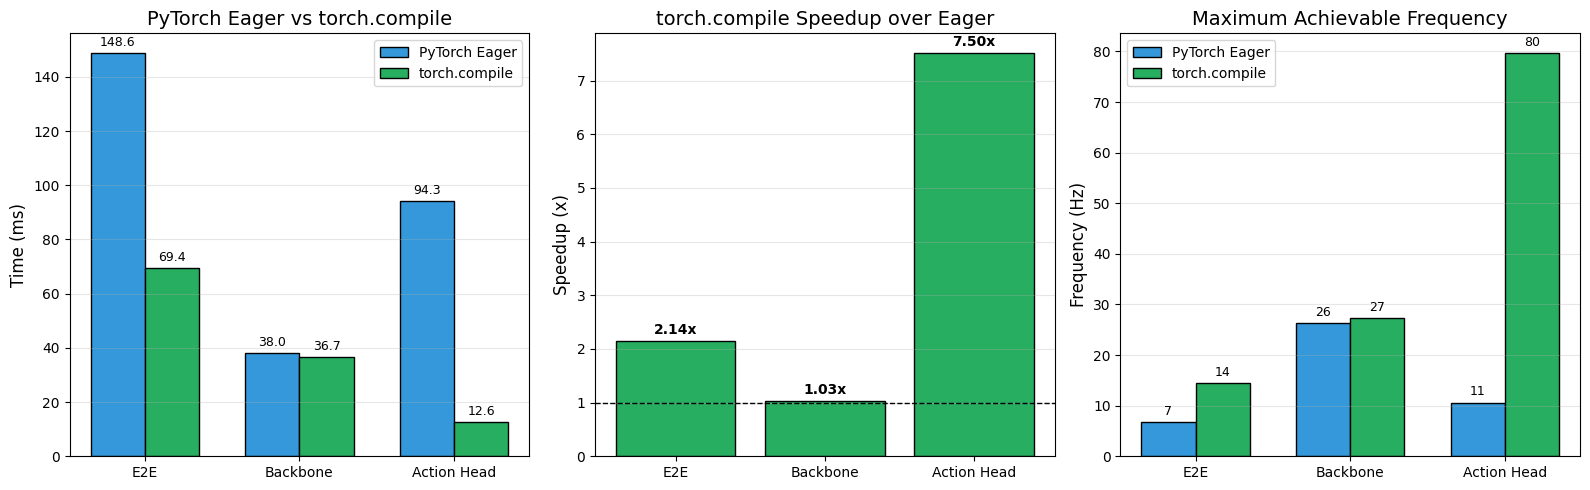

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Side-by-side bar chart of inference times
ax1 = axes[0]
components = ["E2E", "Backbone", "Action Head"]
eager_times = [
    np.mean(timing_results["e2e_time"]) * 1000,
    np.mean(timing_results["backbone_time"]) * 1000,
    np.mean(timing_results["action_head_time"]) * 1000,
]
compiled_times = [
    np.mean(compile_timing_results["e2e_time"]) * 1000,
    np.mean(compile_timing_results["backbone_time"]) * 1000,
    np.mean(compile_timing_results["action_head_time"]) * 1000,
]

x = np.arange(len(components))
width = 0.35

bars1 = ax1.bar(x - width/2, eager_times, width, label='PyTorch Eager', color='#3498db', edgecolor='black')
bars2 = ax1.bar(x + width/2, compiled_times, width, label='torch.compile', color='#27ae60', edgecolor='black')

ax1.set_ylabel('Time (ms)', fontsize=12)
ax1.set_title('PyTorch Eager vs torch.compile', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(components)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars1, eager_times):
    ax1.annotate(f'{val:.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars2, compiled_times):
    ax1.annotate(f'{val:.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Plot 2: Speedup bar chart
ax2 = axes[1]
speedups = [eager_times[i] / compiled_times[i] if compiled_times[i] > 0 else 0 for i in range(len(components))]
colors_speedup = ['#27ae60' if s > 1 else '#e74c3c' for s in speedups]

bars3 = ax2.bar(components, speedups, color=colors_speedup, edgecolor='black')
ax2.axhline(y=1, color='black', linestyle='--', linewidth=1, label='No speedup')
ax2.set_ylabel('Speedup (x)', fontsize=12)
ax2.set_title('torch.compile Speedup over Eager', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars3, speedups):
    ax2.annotate(f'{val:.2f}x', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Max frequency comparison
ax3 = axes[2]
eager_freqs = [1000/t if t > 0 else 0 for t in eager_times]
compiled_freqs = [1000/t if t > 0 else 0 for t in compiled_times]

bars4 = ax3.bar(x - width/2, eager_freqs, width, label='PyTorch Eager', color='#3498db', edgecolor='black')
bars5 = ax3.bar(x + width/2, compiled_freqs, width, label='torch.compile', color='#27ae60', edgecolor='black')

ax3.set_ylabel('Frequency (Hz)', fontsize=12)
ax3.set_title('Maximum Achievable Frequency', fontsize=14)
ax3.set_xticks(x)
ax3.set_xticklabels(components)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

for bar, val in zip(bars4, eager_freqs):
    ax3.annotate(f'{val:.0f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars5, compiled_freqs):
    ax3.annotate(f'{val:.0f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### torch.compile Summary

`torch.compile` with `max-autotune` mode provides JIT compilation optimizations:

**Key Benefits:**
- **Zero setup overhead**: No need to export ONNX or build TensorRT engines
- **Graph optimizations**: Operator fusion and memory planning
- **Kernel optimization**: Auto-tuning for the specific hardware

**Trade-offs:**
- **First inference is slow**: JIT compilation happens on first run
- **Less speedup than TensorRT**: TensorRT typically provides greater acceleration for the DiT action head

## TensorRT Inference Timing

Now let's compare the PyTorch inference with TensorRT. TensorRT accelerates the DiT (Diffusion Transformer) action head, which is the main computational bottleneck.

**Setup Requirements:**
- TensorRT engine built from ONNX export: `~/tensorrt-engine/dit_model_bf16.trt`
- Built using: `python scripts/deployment/build_tensorrt_engine.py`

In [ ]:
# TensorRT Engine Path
TRT_ENGINE_PATH = os.path.expanduser("~/tensorrt-engine/dit_model_bf16.trt")

# Check if TensorRT engine exists
if os.path.exists(TRT_ENGINE_PATH):
    print(f"✓ TensorRT engine found: {TRT_ENGINE_PATH}")
    print(f"  Size: {os.path.getsize(TRT_ENGINE_PATH) / (1024**2):.2f} MB")
    TRT_AVAILABLE = True
else:
    print(f"✗ TensorRT engine not found at: {TRT_ENGINE_PATH}")
    print("  To build the engine, run:")
    print("  python scripts/deployment/export_onnx_n1d6.py --model_path nvidia/GR00T-N1.6-3B --dataset_path <dataset> --output_dir ./groot_n1d6_onnx")
    print("  python scripts/deployment/build_tensorrt_engine.py --onnx ./groot_n1d6_onnx/dit_model.onnx --engine ~/tensorrt-engine/dit_model_bf16.trt --precision bf16")
    TRT_AVAILABLE = False

In [25]:
# Import TensorRT utilities from deployment module (same directory)
from standalone_inference_script import (
    TensorRTDiTWrapper,
    replace_dit_with_tensorrt,
)

In [26]:
if TRT_AVAILABLE:
    # Load a fresh policy for TensorRT
    print("Loading fresh policy for TensorRT...")
    policy_trt = Gr00tPolicy(
        model_path=MODEL_PATH,
        embodiment_tag=EmbodimentTag(EMBODIMENT_TAG),
        device=device,
        strict=True,
    )
    
    # Replace DiT with TensorRT engine
    replace_dit_with_tensorrt(policy_trt, TRT_ENGINE_PATH)
    print(f"\nTensorRT policy ready!")
else:
    print("Skipping TensorRT setup - engine not available")

Loading fresh policy for TensorRT...
Tune backbone llm: False
Tune backbone visual: False
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.q_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.k_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.v_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.o_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.q_norm.weight
Backbone trainable parameter: model.language_model.model.layers.12.self_attn.k_norm.weight
Backbone trainable parameter: model.language_model.model.layers.12.mlp.gate_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.mlp.up_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.mlp.down_proj.weight
Backbone trainable parameter: model.language_model.model.layers.12.input_layernorm.weight
Backbone tra

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]



TensorRT policy ready!


In [27]:
if TRT_AVAILABLE:
    # Warmup runs for TensorRT
    print("Running TensorRT warmup iterations...")
    for _ in range(3):
        with torch.inference_mode():
            _ = policy_trt.get_action(observation)
    torch.cuda.synchronize()
    print("TensorRT warmup complete!")
    
    # Storage for TensorRT timing results
    trt_timing_results = {
        "e2e_time": [],
        "data_prep_time": [],
        "backbone_time": [],
        "action_head_time": [],
    }

Running TensorRT warmup iterations...
[12/11/2025-13:09:19] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
TensorRT warmup complete!


### Measure TensorRT E2E Inference Time

In [28]:
if TRT_AVAILABLE:
    print("Measuring TensorRT full E2E inference time...")
    for i in range(NUM_ITERATIONS):
        torch.cuda.synchronize()
        start = time.perf_counter()
        
        with torch.inference_mode():
            action, _ = policy_trt.get_action(observation)
        
        torch.cuda.synchronize()
        end = time.perf_counter()
        trt_timing_results["e2e_time"].append(end - start)

    e2e_mean = np.mean(trt_timing_results["e2e_time"]) * 1000
    e2e_std = np.std(trt_timing_results["e2e_time"]) * 1000
    print(f"TensorRT E2E inference time: {e2e_mean:.2f} ± {e2e_std:.2f} ms")

Measuring TensorRT full E2E inference time...
TensorRT E2E inference time: 54.59 ± 9.11 ms


### Measure TensorRT Component-wise Inference Time

In [29]:
if TRT_AVAILABLE:
    # Data preparation is the same regardless of inference mode (TensorRT doesn't affect it)
    # Use the shared data preparation timing from PyTorch Eager benchmark for consistency
    trt_timing_results["data_prep_time"] = timing_results["data_prep_time"].copy()
    
    print("Measuring TensorRT component-wise inference time...")
    print("  (Using shared data preparation timing from PyTorch Eager benchmark)")

    for i in range(NUM_ITERATIONS):
        collated_inputs, states = prepare_model_inputs(policy_trt, observation)
        
        # 1. Backbone timing (same as PyTorch - backbone is not replaced)
        torch.cuda.synchronize()
        start_backbone = time.perf_counter()
        
        with torch.inference_mode():
            backbone_inputs, action_inputs = policy_trt.model.prepare_input(collated_inputs)
            backbone_outputs = policy_trt.model.backbone(backbone_inputs)
        
        torch.cuda.synchronize()
        end_backbone = time.perf_counter()
        trt_timing_results["backbone_time"].append(end_backbone - start_backbone)
        
        # 2. Action head timing (using TensorRT DiT)
        torch.cuda.synchronize()
        start_action = time.perf_counter()
        
        with torch.inference_mode():
            action_outputs = policy_trt.model.action_head.get_action(backbone_outputs, action_inputs)
        
        torch.cuda.synchronize()
        end_action = time.perf_counter()
        trt_timing_results["action_head_time"].append(end_action - start_action)

    print(f"\nTensorRT Component-wise timing (averaged over {NUM_ITERATIONS} iterations):")
    print(f"  Data preparation: {np.mean(trt_timing_results['data_prep_time'])*1000:.2f} ± {np.std(trt_timing_results['data_prep_time'])*1000:.2f} ms (shared)")
    print(f"  Backbone:         {np.mean(trt_timing_results['backbone_time'])*1000:.2f} ± {np.std(trt_timing_results['backbone_time'])*1000:.2f} ms")
    print(f"  Action head (TRT):{np.mean(trt_timing_results['action_head_time'])*1000:.2f} ± {np.std(trt_timing_results['action_head_time'])*1000:.2f} ms")

Measuring TensorRT component-wise inference time...
  (Using shared data preparation timing from PyTorch Eager benchmark)

TensorRT Component-wise timing (averaged over 20 iterations):
  Data preparation: 4.72 ± 0.72 ms (shared)
  Backbone:         35.84 ± 0.98 ms
  Action head (TRT):10.39 ± 0.03 ms


## PyTorch vs TensorRT Comparison

Now let's compare the timing results between PyTorch and TensorRT side by side.

In [30]:
if TRT_AVAILABLE:
    # Create comparison DataFrame
    comparison_data = {
        "Component": [
            "Full E2E Inference",
            "Data Preparation",
            "Backbone (VLM)",
            "Action Head",
        ],
        "PyTorch (ms)": [
            np.mean(timing_results["e2e_time"]) * 1000,
            np.mean(timing_results["data_prep_time"]) * 1000,
            np.mean(timing_results["backbone_time"]) * 1000,
            np.mean(timing_results["action_head_time"]) * 1000,
        ],
        "TensorRT (ms)": [
            np.mean(trt_timing_results["e2e_time"]) * 1000,
            np.mean(trt_timing_results["data_prep_time"]) * 1000,
            np.mean(trt_timing_results["backbone_time"]) * 1000,
            np.mean(trt_timing_results["action_head_time"]) * 1000,
        ],
    }
    
    # Calculate speedup
    comparison_data["Speedup"] = [
        comparison_data["PyTorch (ms)"][i] / comparison_data["TensorRT (ms)"][i] 
        if comparison_data["TensorRT (ms)"][i] > 0 else 0
        for i in range(len(comparison_data["Component"]))
    ]
    
    # Calculate max frequency
    comparison_data["PyTorch (Hz)"] = [1000 / t if t > 0 else 0 for t in comparison_data["PyTorch (ms)"]]
    comparison_data["TensorRT (Hz)"] = [1000 / t if t > 0 else 0 for t in comparison_data["TensorRT (ms)"]]

    df_comparison = pd.DataFrame(comparison_data)
    
    print("\n" + "="*100)
    print("PYTORCH vs TENSORRT COMPARISON")
    print("="*100)
    print(df_comparison.to_string(index=False, float_format=lambda x: f"{x:.2f}"))
    
    print("\n" + "="*100)
    print("KEY INSIGHTS")
    print("="*100)
    
    # E2E speedup
    e2e_speedup = comparison_data["PyTorch (ms)"][0] / comparison_data["TensorRT (ms)"][0]
    print(f"\n✓ E2E Speedup: {e2e_speedup:.2f}x faster with TensorRT")
    
    # Action head speedup (the main optimization target)
    ah_speedup = comparison_data["PyTorch (ms)"][3] / comparison_data["TensorRT (ms)"][3]
    print(f"✓ Action Head Speedup: {ah_speedup:.2f}x faster with TensorRT")
    
    # Time saved
    time_saved = comparison_data["PyTorch (ms)"][0] - comparison_data["TensorRT (ms)"][0]
    print(f"\n✓ Time saved per inference: {time_saved:.2f} ms")
    
    # Frequency improvement
    pytorch_hz = 1000 / comparison_data["PyTorch (ms)"][0]
    trt_hz = 1000 / comparison_data["TensorRT (ms)"][0]
    print(f"✓ E2E Frequency: {pytorch_hz:.1f} Hz (PyTorch) → {trt_hz:.1f} Hz (TensorRT)")
else:
    print("TensorRT comparison not available - engine not found")


PYTORCH vs TENSORRT COMPARISON
         Component  PyTorch (ms)  TensorRT (ms)  Speedup  PyTorch (Hz)  TensorRT (Hz)
Full E2E Inference        148.62          54.59     2.72          6.73          18.32
  Data Preparation          4.72           4.72     1.00        211.85         211.85
    Backbone (VLM)         37.96          35.84     1.06         26.34          27.90
       Action Head         94.28          10.39     9.08         10.61          96.27

KEY INSIGHTS

✓ E2E Speedup: 2.72x faster with TensorRT
✓ Action Head Speedup: 9.08x faster with TensorRT

✓ Time saved per inference: 94.03 ms
✓ E2E Frequency: 6.7 Hz (PyTorch) → 18.3 Hz (TensorRT)


### PyTorch vs TensorRT Visualization

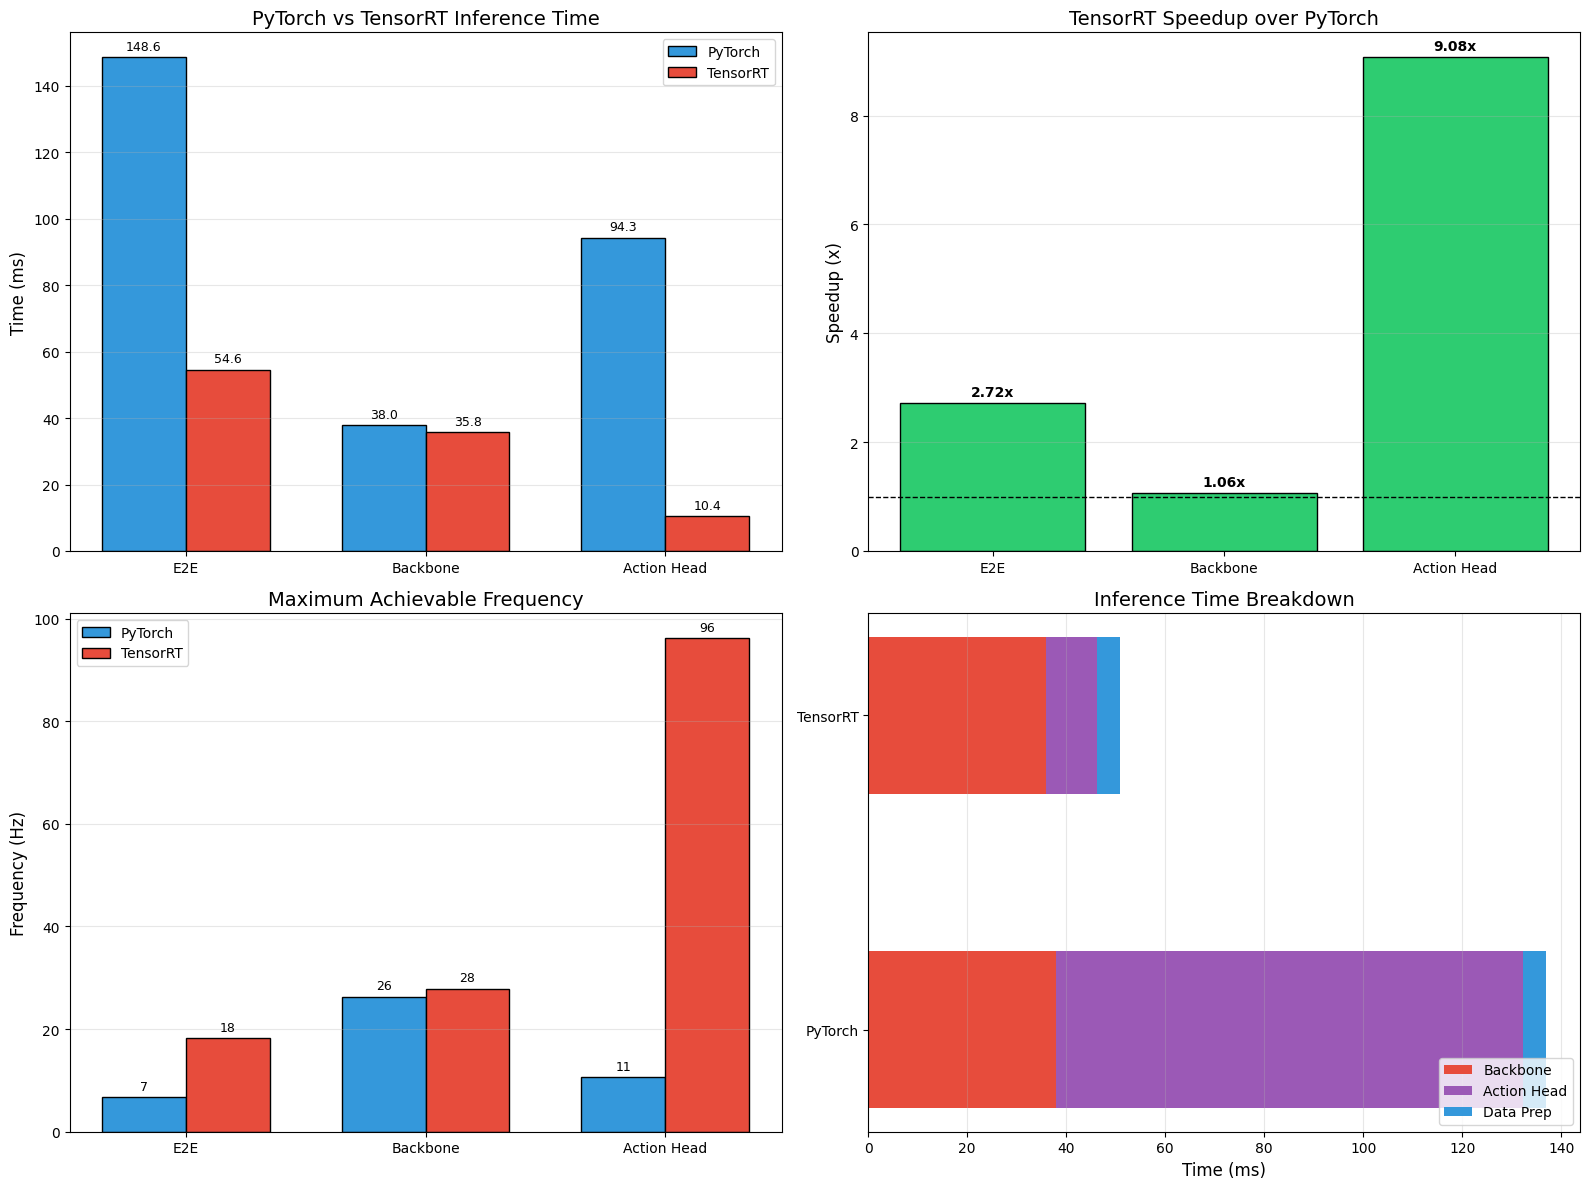

In [31]:
if TRT_AVAILABLE:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Side-by-side bar chart of inference times
    ax1 = axes[0, 0]
    components = ["E2E", "Backbone", "Action Head"]
    pytorch_times = [
        np.mean(timing_results["e2e_time"]) * 1000,
        np.mean(timing_results["backbone_time"]) * 1000,
        np.mean(timing_results["action_head_time"]) * 1000,
    ]
    trt_times = [
        np.mean(trt_timing_results["e2e_time"]) * 1000,
        np.mean(trt_timing_results["backbone_time"]) * 1000,
        np.mean(trt_timing_results["action_head_time"]) * 1000,
    ]
    
    x = np.arange(len(components))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, pytorch_times, width, label='PyTorch', color='#3498db', edgecolor='black')
    bars2 = ax1.bar(x + width/2, trt_times, width, label='TensorRT', color='#e74c3c', edgecolor='black')
    
    ax1.set_ylabel('Time (ms)', fontsize=12)
    ax1.set_title('PyTorch vs TensorRT Inference Time', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(components)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars1, pytorch_times):
        ax1.annotate(f'{val:.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    for bar, val in zip(bars2, trt_times):
        ax1.annotate(f'{val:.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    # Plot 2: Speedup bar chart
    ax2 = axes[0, 1]
    speedups = [pytorch_times[i] / trt_times[i] if trt_times[i] > 0 else 0 for i in range(len(components))]
    colors_speedup = ['#2ecc71' if s > 1 else '#e74c3c' for s in speedups]
    
    bars3 = ax2.bar(components, speedups, color=colors_speedup, edgecolor='black')
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=1, label='No speedup')
    ax2.set_ylabel('Speedup (x)', fontsize=12)
    ax2.set_title('TensorRT Speedup over PyTorch', fontsize=14)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars3, speedups):
        ax2.annotate(f'{val:.2f}x', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot 3: Max frequency comparison
    ax3 = axes[1, 0]
    pytorch_freqs = [1000/t if t > 0 else 0 for t in pytorch_times]
    trt_freqs = [1000/t if t > 0 else 0 for t in trt_times]
    
    bars4 = ax3.bar(x - width/2, pytorch_freqs, width, label='PyTorch', color='#3498db', edgecolor='black')
    bars5 = ax3.bar(x + width/2, trt_freqs, width, label='TensorRT', color='#e74c3c', edgecolor='black')
    
    ax3.set_ylabel('Frequency (Hz)', fontsize=12)
    ax3.set_title('Maximum Achievable Frequency', fontsize=14)
    ax3.set_xticks(x)
    ax3.set_xticklabels(components)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars4, pytorch_freqs):
        ax3.annotate(f'{val:.0f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    for bar, val in zip(bars5, trt_freqs):
        ax3.annotate(f'{val:.0f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    # Plot 4: Time breakdown pie charts
    ax4 = axes[1, 1]
    
    # Create a stacked horizontal bar chart showing time breakdown
    breakdown_labels = ['PyTorch', 'TensorRT']
    backbone_times = [np.mean(timing_results["backbone_time"])*1000, np.mean(trt_timing_results["backbone_time"])*1000]
    action_head_times = [np.mean(timing_results["action_head_time"])*1000, np.mean(trt_timing_results["action_head_time"])*1000]
    data_prep_times = [np.mean(timing_results["data_prep_time"])*1000, np.mean(trt_timing_results["data_prep_time"])*1000]
    
    y_pos = np.arange(len(breakdown_labels))
    
    ax4.barh(y_pos, backbone_times, height=0.5, label='Backbone', color='#e74c3c')
    ax4.barh(y_pos, action_head_times, height=0.5, left=backbone_times, label='Action Head', color='#9b59b6')
    ax4.barh(y_pos, data_prep_times, height=0.5, left=[backbone_times[i]+action_head_times[i] for i in range(2)], label='Data Prep', color='#3498db')
    
    ax4.set_xlabel('Time (ms)', fontsize=12)
    ax4.set_title('Inference Time Breakdown', fontsize=14)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(breakdown_labels)
    ax4.legend(loc='lower right')
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("TensorRT visualization not available - engine not found")

## Final Summary

This notebook analyzed the inference timing breakdown for the GR00T model with three backends:

### Inference Modes Compared:
1. **PyTorch Eager**: Standard PyTorch execution without optimizations
2. **torch.compile**: PyTorch 2.0+ JIT compilation with `max-autotune` mode
3. **TensorRT**: Optimized DiT action head with TensorRT engine

### Key Findings:

1. **TensorRT Acceleration**: TensorRT accelerates the DiT (Diffusion Transformer) action head the most, providing the highest speedup for production deployments.

2. **torch.compile Benefits**: Provides meaningful speedup over eager mode with zero setup overhead - good for development and quick experiments.

3. **Backbone Unchanged**: The backbone (VLM) timing remains similar across all modes as TensorRT only optimizes the DiT.

### Deployment Recommendations:

- **Use TensorRT** for production deployments where inference speed is critical
- **Use torch.compile** for development/prototyping when TensorRT setup is not feasible
- **Use PyTorch Eager** for debugging and model development

In [32]:
# Final comprehensive summary
print("\n" + "="*100)
print("FINAL COMPREHENSIVE SUMMARY")
print("="*100)
print(f"\nHardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Model: {MODEL_PATH}")
print(f"Action Horizon: {policy.model.action_head.action_horizon}")
print(f"Denoising Steps: {policy.model.action_head.num_inference_timesteps}")

print("\n" + "-"*100)
print("PYTORCH EAGER TIMING RESULTS")
print("-"*100)
print(f"  E2E Inference:  {np.mean(timing_results['e2e_time'])*1000:.2f} ms ({1000/(np.mean(timing_results['e2e_time'])*1000):.1f} Hz)")
print(f"  Backbone Only:  {np.mean(timing_results['backbone_time'])*1000:.2f} ms ({1000/(np.mean(timing_results['backbone_time'])*1000):.1f} Hz)")
print(f"  Action Head:    {np.mean(timing_results['action_head_time'])*1000:.2f} ms ({1000/(np.mean(timing_results['action_head_time'])*1000):.1f} Hz)")

print("\n" + "-"*100)
print("torch.compile TIMING RESULTS (mode='max-autotune')")
print("-"*100)
print(f"  E2E Inference:  {np.mean(compile_timing_results['e2e_time'])*1000:.2f} ms ({1000/(np.mean(compile_timing_results['e2e_time'])*1000):.1f} Hz)")
print(f"  Backbone Only:  {np.mean(compile_timing_results['backbone_time'])*1000:.2f} ms ({1000/(np.mean(compile_timing_results['backbone_time'])*1000):.1f} Hz)")
print(f"  Action Head:    {np.mean(compile_timing_results['action_head_time'])*1000:.2f} ms ({1000/(np.mean(compile_timing_results['action_head_time'])*1000):.1f} Hz)")

if TRT_AVAILABLE:
    print("\n" + "-"*100)
    print("TENSORRT TIMING RESULTS")
    print("-"*100)
    print(f"  E2E Inference:  {np.mean(trt_timing_results['e2e_time'])*1000:.2f} ms ({1000/(np.mean(trt_timing_results['e2e_time'])*1000):.1f} Hz)")
    print(f"  Backbone Only:  {np.mean(trt_timing_results['backbone_time'])*1000:.2f} ms ({1000/(np.mean(trt_timing_results['backbone_time'])*1000):.1f} Hz)")
    print(f"  Action Head:    {np.mean(trt_timing_results['action_head_time'])*1000:.2f} ms ({1000/(np.mean(trt_timing_results['action_head_time'])*1000):.1f} Hz)")

print("\n" + "-"*100)
print("SPEEDUP SUMMARY (vs PyTorch Eager)")
print("-"*100)
compile_e2e_speedup = np.mean(timing_results['e2e_time']) / np.mean(compile_timing_results['e2e_time'])
compile_ah_speedup = np.mean(timing_results['action_head_time']) / np.mean(compile_timing_results['action_head_time'])
print(f"  torch.compile E2E Speedup:      {compile_e2e_speedup:.2f}x")
print(f"  torch.compile Action Head:      {compile_ah_speedup:.2f}x")

if TRT_AVAILABLE:
    trt_e2e_speedup = np.mean(timing_results['e2e_time']) / np.mean(trt_timing_results['e2e_time'])
    trt_ah_speedup = np.mean(timing_results['action_head_time']) / np.mean(trt_timing_results['action_head_time'])
    print(f"  TensorRT E2E Speedup:           {trt_e2e_speedup:.2f}x")
    print(f"  TensorRT Action Head Speedup:   {trt_ah_speedup:.2f}x")

print("\n" + "="*100)


FINAL COMPREHENSIVE SUMMARY

Hardware: NVIDIA H100 80GB HBM3
Model: nvidia/GR00T-N1.6-3B
Action Horizon: 50
Denoising Steps: 4

----------------------------------------------------------------------------------------------------
PYTORCH EAGER TIMING RESULTS
----------------------------------------------------------------------------------------------------
  E2E Inference:  148.62 ms (6.7 Hz)
  Backbone Only:  37.96 ms (26.3 Hz)
  Action Head:    94.28 ms (10.6 Hz)

----------------------------------------------------------------------------------------------------
torch.compile TIMING RESULTS (mode='max-autotune')
----------------------------------------------------------------------------------------------------
  E2E Inference:  69.38 ms (14.4 Hz)
  Backbone Only:  36.71 ms (27.2 Hz)
  Action Head:    12.56 ms (79.6 Hz)

----------------------------------------------------------------------------------------------------
TENSORRT TIMING RESULTS
--------------------------------------